<a href="https://colab.research.google.com/github/riyanpacul/COVID19-Analysis-and-Modelling/blob/main/Covid_19_Analysis_and_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# drive to open file from GDrive
from google.colab import drive
drive.mount('/content/drive')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Bismillah

*Coronavirus disease (COVID-19) is an infectious disease caused by a newly discovered coronavirus. Most people infected with COVID-19 virus will experience mild to moderate respiratory illness and recover without requiring special treatment. Older people, and those with underlying medical problems like cardiovascular disease, diabetes, chronic respiratory disease, and cancer are more likely to develop serious illness.*

COVID-19 adalah penyakit menular yang disebabkan oleh virus corona yang menjangkiti hampir seluruh dunia sekitar tahun 2019-2022. Sebagian besar orang yang terjangkit penyakit ini mengalami sakit pernafasan ringan sampai sedang dan bisa sembuh tanpa melakukan perawatan medis apapun. Namun, orang tua (lansia) dan orang yang punya riwayat penyakit tertentu dapat mengalami gejala yang serius.

Selama masa pandemi tersebut, salah satu masalah utama yang dialami oleh tenaga medis adalah kekurangan sumber daya dan perencanaan yang matang untuk penyebarannya. Kemampuan dalam memprediksi sumber daya yang dibutuhkan seseorang, baik saat dinyatakan positif maupun tidak bahkan sebelum terjadi dapat membantu para pihak berwenang dalam mendapatkan dan mengatur sumber daya yang diperlukan dalam rangka menyelamatkan nyawa pasien.

Tujuan kali ini adalah memprediksi apakah pasien COVID 19 yang tercatat dalam dataset ini masuk kategori risti (risiko tinggi) terjangkit COVID maupun tidak. Dataset untuk analisis kali ini berasal dari pemerintah Meksiko. (https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico).
Dataset ini berisi data informasi terkait pasien yang dirahasiakan identitasnya (*anonymous*) beserta kondisi awalnya (pre-condition).

In [ ]:
# Melakukan load dataset
data_covid = pd.read_csv('/content/drive/MyDrive/Project Data Science/Covid Dataset/Covid Data.csv')
print('Dataset ini berisi tabel yang terdiri dari {} baris dan {} kolom'.format(data_covid.shape[0],data_covid.shape[1]))
data_covid.head()

Dataset ini berisi tabel yang terdiri dari 1048575 baris dan 21 kolom


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


# Cleaning Data

Sebelum dibuat model dalam machine learning, maka kita harus melakukan pembersihan (*cleaning*) data terlebih dahulu agar model yang dihasilkan memiliki pengukuran yang baik dan optimal. Pembersihan data meliputi data duplikat, data yang hilang, dan outlier.

## Data duplikat

In [ ]:
print('Data duplikat dari dataset ini berjumlah {} data atau {} % dari total data yang tersaji di dataset ini.'
.format(data_covid.duplicated().sum(),(data_covid.duplicated().sum()/data_covid.shape[0])*100))

Data duplikat dari dataset ini berjumlah 812049 data atau 77.44310135183463 % dari total data yang tersaji di dataset ini.


Bisa dibilang lebih dari 75% dari total data merupakan data duplikat, bisa saja itu berasal dari beberapa pasien yang terjangkit COVID lebih dari satu kali. Namun, untuk mengoptimalkan model machine learning, maka data duplikat terpaksa dibersihkan sehingga hasil model yang dibuat nanti dapat membantu pihak terkait untuk mengidentifikasi pasien yang berulang kali dilaporkan telah terjangkit COVID.

In [ ]:
data_covid = data_covid.drop_duplicates()

## Data Hilang (Missing Value)

In [ ]:
# Fungsi untuk menghitung jumlah missing values berdasarkan kolom
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Missing value percentage
    mis_val_pct = 100 * df.isnull().sum() / len(df)

    # missing value table
    mis_val_tab = pd.concat([mis_val, mis_val_pct], axis=1)

    # Rename the columns
    mis_val_tab_col_renamed = mis_val_tab.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending after removing rows with missing% == 0
    mis_val_tab_col_renamed = mis_val_tab_col_renamed[
        mis_val_tab_col_renamed.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(mis_val_tab_col_renamed.shape[0]) +
           " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_tab_col_renamed

In [ ]:
missing_values_table(data_covid)

Your selected dataframe has 21 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Oke, dataset ini tidak mempunyai missing value. Namun menurut penjelasan dari sumber dataset ini, data yang mempunyai missing value sengaja diberi nilai '97' atau '99'. Oleh karena itu, kita menanganinya lebih lanjut setelah ini.

# Exploratory Data Analysis (EDA)

Tujuan melakukan EDA ini umtuk melihat insight yang ada di dalam dataset ini

In [ ]:
data_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236526 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   USMER                 236526 non-null  int64 
 1   MEDICAL_UNIT          236526 non-null  int64 
 2   SEX                   236526 non-null  int64 
 3   PATIENT_TYPE          236526 non-null  int64 
 4   DATE_DIED             236526 non-null  object
 5   INTUBED               236526 non-null  int64 
 6   PNEUMONIA             236526 non-null  int64 
 7   AGE                   236526 non-null  int64 
 8   PREGNANT              236526 non-null  int64 
 9   DIABETES              236526 non-null  int64 
 10  COPD                  236526 non-null  int64 
 11  ASTHMA                236526 non-null  int64 
 12  INMSUPR               236526 non-null  int64 
 13  HIPERTENSION          236526 non-null  int64 
 14  OTHER_DISEASE         236526 non-null  int64 
 15  CARDIOVASCULAR  

## Final Classification

<Axes: >

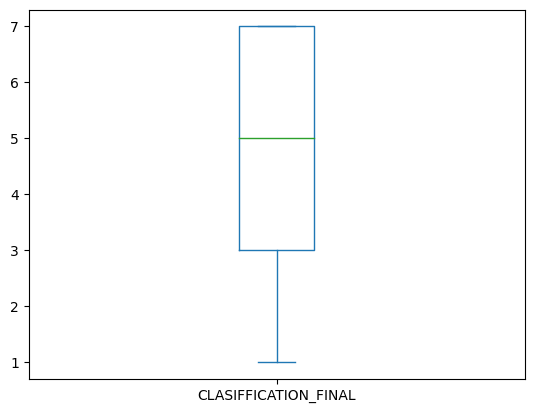

In [ ]:
data_covid['CLASIFFICATION_FINAL'].plot(kind='box')

In [ ]:
data_covid['CLASIFFICATION_FINAL'].value_counts(normalize=True)

3    0.451164
7    0.325863
6    0.142179
5    0.046084
1    0.019998
2    0.007805
4    0.006908
Name: CLASIFFICATION_FINAL, dtype: float64

<Axes: xlabel='CLASIFFICATION_FINAL', ylabel='count'>

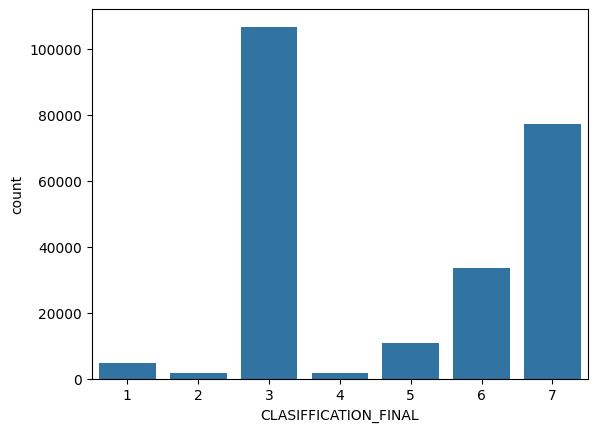

In [ ]:
sns.countplot(x='CLASIFFICATION_FINAL',data=data_covid)

In [ ]:
def diagnose(x):
  if x < 4:
    return 'Diagnosed'
  else:
    return 'Undiagnosed'

In [ ]:
data_covid['DIAGNOSE'] = data_covid['CLASIFFICATION_FINAL'].apply(diagnose)
data_covid['DIAGNOSE']

0            Diagnosed
1          Undiagnosed
2            Diagnosed
3          Undiagnosed
4            Diagnosed
              ...     
1048568    Undiagnosed
1048569    Undiagnosed
1048571    Undiagnosed
1048572    Undiagnosed
1048574    Undiagnosed
Name: DIAGNOSE, Length: 236526, dtype: object

<Axes: xlabel='DIAGNOSE', ylabel='count'>

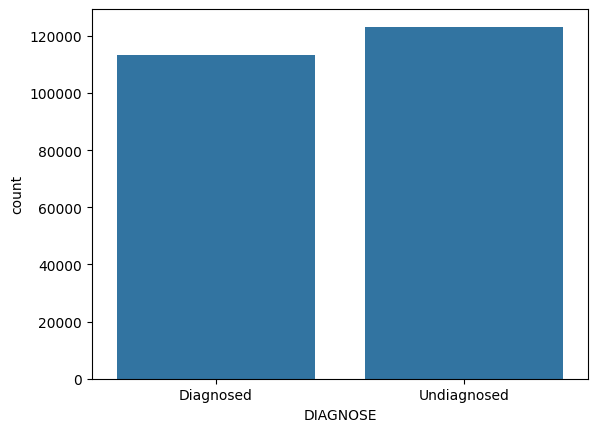

In [ ]:
sns.countplot(x='DIAGNOSE',data=data_covid)

Dalam kolom Final Clasiffication, ditunjukan dengan nilai bilangan 1-7. Nomor 1-3 berarti pasien tersebut didiagnosa terjangkit COVID, sementara nomor 4-7 berarti pasien tersebut tidak terjangkit COVID. Namun, belum tentu pasien yang mendapat nomor 4-7 tidak terjangkit COVID. Menurut penjelasan dari sumber dataset, bisa jadi hasil tersebut tidak meyakinkan.

Kemudian, kita mengelompokkan nilai data Final Clasiffication menjadi 'Diagnosed' dan 'Undiagnosed'. Diagnosed berarti pasien tersebut didiagnosa terjangkit COVID, sementara Undiagnosed tidak. Hasil menunjukkan bahwa jumlah pasien Undiagnosed lebih banyak daripada pasien 'Diagnosed' dengan selisih yang tidak terlalu jauh (jomplang).

## Kematian

In [ ]:
data_covid['DATE_DIED'].value_counts()

9999-99-99    160561
07/07/2020       984
06/07/2020       980
13/07/2020       970
16/06/2020       960
               ...  
24/11/2020         1
17/12/2020         1
08/12/2020         1
16/03/2021         1
22/04/2021         1
Name: DATE_DIED, Length: 401, dtype: int64

In [ ]:
def death_status(x):
  if x == '9999-99-99':
    return 'Survived'
  else:
    return 'Deceased'

In [ ]:
data_covid['DEATH_STATUS'] = data_covid['DATE_DIED'].apply(death_status)
data_covid['DEATH_STATUS']

0          Deceased
1          Deceased
2          Deceased
3          Deceased
4          Deceased
             ...   
1048568    Survived
1048569    Survived
1048571    Survived
1048572    Survived
1048574    Survived
Name: DEATH_STATUS, Length: 236526, dtype: object

In [ ]:
def barPerc(df,xVar,ax):
    '''
    barPerc(): Add percentage for hues to bar plots
    args:
        df: pandas dataframe
        xVar: (string) X variable
        ax: Axes object (for Seaborn Countplot/Bar plot or
                         pandas bar plot)
    '''
    # 1. how many X categories
    ##   check for NaN and remove
    numX=len([x for x in df[xVar].unique() if x==x])

    # 2. The bars are created in hue order, organize them
    bars = ax.patches
    ## 2a. For each X variable
    for ind in range(numX):
        ## 2b. Get every hue bar
        ##     ex. 8 X categories, 4 hues =>
        ##    [0, 8, 16, 24] are hue bars for 1st X category
        hueBars=bars[ind:][::numX]
        ## 2c. Get the total height (for percentages)
        total = sum([x.get_height() for x in hueBars])

        # 3. Print the percentage on the bars
        for bar in hueBars:
            ax.text(bar.get_x() + bar.get_width()/2.,
                    bar.get_height(),
                    f'{bar.get_height()/total:.0%}',
                    ha="center",va="bottom")

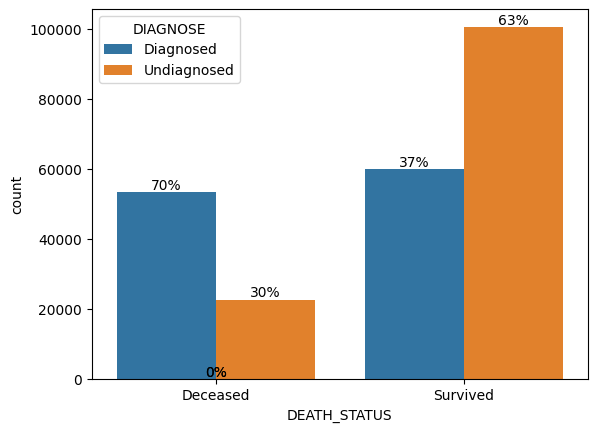

In [ ]:
ax = sns.countplot(x='DEATH_STATUS', data=data_covid, hue='DIAGNOSE')
barPerc(data_covid, 'DEATH_STATUS', ax)

In [ ]:
data_covid['DEATH_STATUS'].value_counts()

Survived    160561
Deceased     75965
Name: DEATH_STATUS, dtype: int64

Dari grafik tersebut, bisa dilihat bahwa pasien yang terjangkit COVID mempunyai risiko kematian yang tinggi daripada pasien yang tidak terjangkit. Ini menunjukkan bahwa COVID sangat berbahaya, terlepas bagi riwayat penyakitnya. Untuk masalah riwayat penyakit dari pasien tersebut, bisa dianalisis setelah ini.

Dari grafik itu juga menunjukkan bahwa pasien yang terjangkit COVID banyak yang masih bisa selamat. Mungkin dikarenakan oleh penanganan medis yang baik dan gaya hidup yang bagus. Tapi sekali lagi, hasil mengenai diagnosa COVID masih belum cukup meyakinkan terutama bagi pasien yang selamat. Jadi kita harus melakukan analisis lebih lanjut mengenai gaya hidup dan riwayat penyakit.

## Umur

<Axes: >

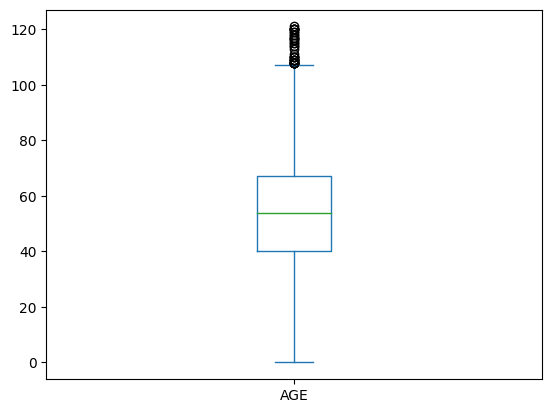

In [ ]:
data_covid['AGE'].plot(kind='box')

<Axes: xlabel='AGE', ylabel='Count'>

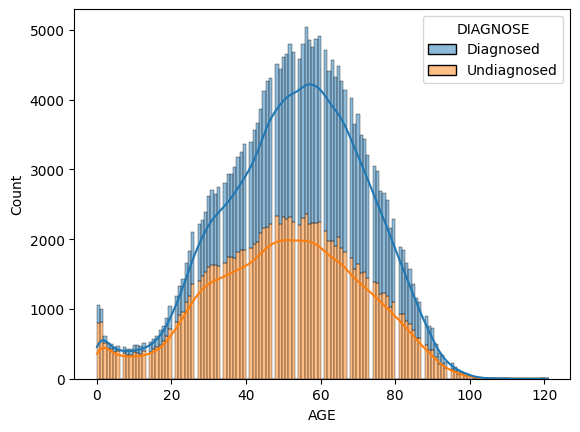

In [ ]:
sns.histplot(data=data_covid, x='AGE', hue='DIAGNOSE', multiple='stack', kde=True)

<Axes: xlabel='AGE', ylabel='Count'>

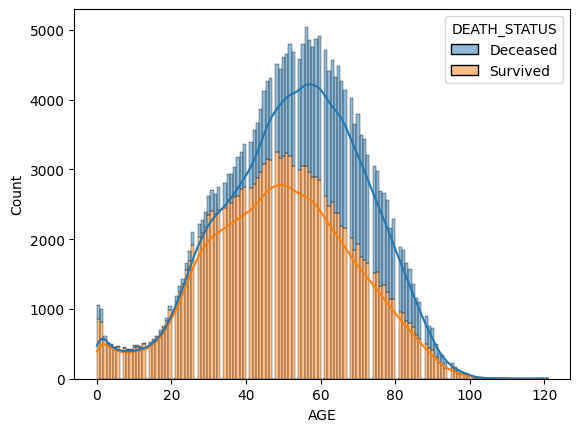

In [ ]:
sns.histplot(data=data_covid, x='AGE', hue='DEATH_STATUS', multiple='stack', kde=True,)

Dari kedua grafik histogram umur pasien di atas, bisa dilihat bahwa COVID banyak menjangkiti pasien berusia sekitar 40-60 tahun dan di rentang usia tersebut juga, banyak pasien yang akhirnya meninggal dunia. Bisa jadi, di rentang usia itu juga banyak pasien terjangkit COVID yang meninggal dunia. Oleh karena itu, para tenaga medis disarankan untuk memperhatikan lebih dalam lagi terhadap pasien di rentang usia tersebut.

Selain iu, tenaga medis juga harus memperhatikan bayi yang baru lahir sampai berumur 1 tahun dikarenakan banyak pasien bayi yang terjangkit COVID dan banyak yang meninggal dunia.

## Jenis Kelamin

In [ ]:
data_covid['SEX'].value_counts()

2    129503
1    107023
Name: SEX, dtype: int64

Keterangan (menurut sumber dataset)
1.   Perempuan
2.   Laki-laki



In [ ]:
sex = {1:'Female', 2:'Male'}

In [ ]:
data_covid['SEX'] = data_covid['SEX'].map(sex)

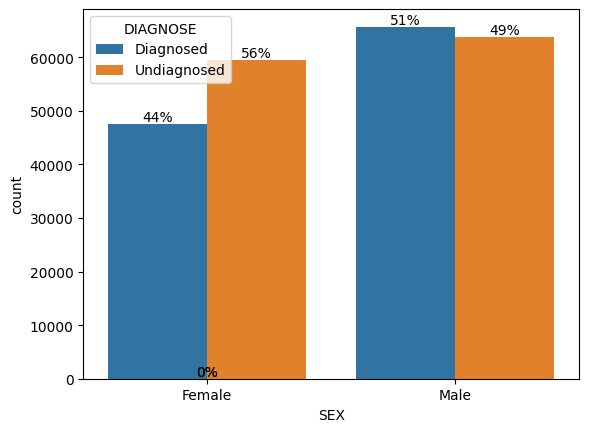

In [ ]:
ax = sns.countplot(x='SEX', data=data_covid, hue='DIAGNOSE')
barPerc(data_covid, 'SEX', ax)

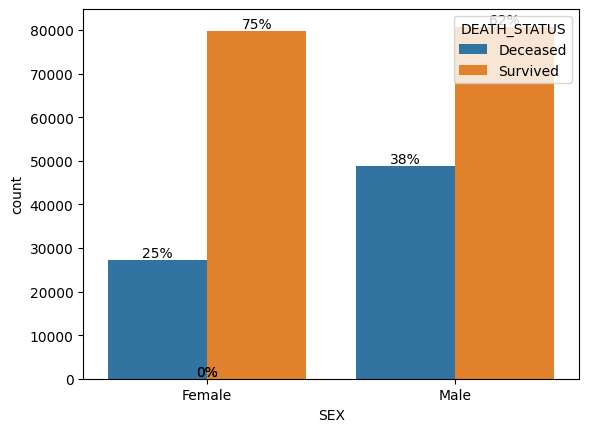

In [ ]:
ax = sns.countplot(x='SEX', data=data_covid, hue='DEATH_STATUS')
barPerc(data_covid, 'SEX', ax)

Pasien laki-laki lebih banyak daripada perempuan dengan selisih sekitar hampir 30.000 pasien. Kemudian, pasien laki-laki lebih banyak yang terjangkit COVID daripada yang tidak terjangkit meskipun selisihnya tidak jomplang. Di lain pihak, pasien perempuan lebih banyak yang selamat dari COVID. Oleh karena itu, meskipun laki-laki lebih kuat daripada perempuan secara fisik, namun laki-laki lebih banyak yang terjangkit COVID. Hal itu disebabkan oleh kelelahan, stres, atau sering berinteraksi dengan banyak orang.

## Tipe Pasien

In [ ]:
data_covid['PATIENT_TYPE'].value_counts()

2    136644
1     99882
Name: PATIENT_TYPE, dtype: int64

Keterangan

1.   Returned Home
2.   Hospitalization



In [ ]:
patient_type = {1:'Returned Home', 2:'Hospitalization'}

In [ ]:
data_covid['PATIENT_TYPE'] = data_covid['PATIENT_TYPE'].map(patient_type)

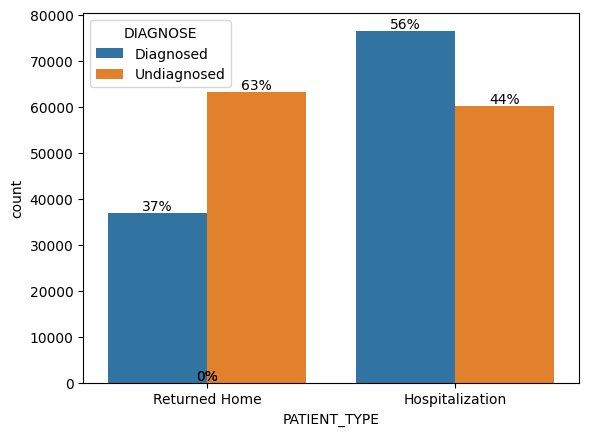

In [ ]:
ax = sns.countplot(x='PATIENT_TYPE', data=data_covid, hue='DIAGNOSE')
barPerc(data_covid, 'PATIENT_TYPE', ax)

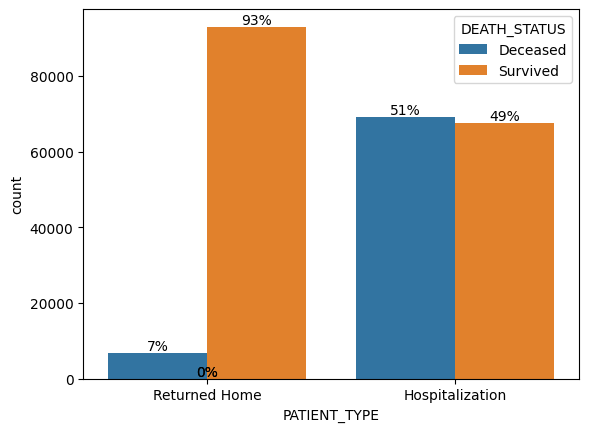

In [ ]:
ax = sns.countplot(x='PATIENT_TYPE', data=data_covid, hue='DEATH_STATUS')
barPerc(data_covid, 'PATIENT_TYPE', ax)

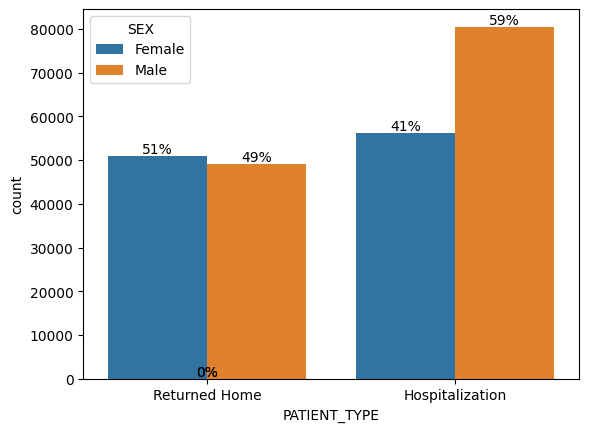

In [ ]:
ax = sns.countplot(x='PATIENT_TYPE', data=data_covid, hue='SEX')
barPerc(data_covid, 'PATIENT_TYPE', ax)

Bisa dilihat bahwa pasien laki-laki lebih banyak yang dirawat di rumah sakit, sementara pasien laki-laki dan perempuan cenderung seimbang terkait jumlah pasien yang hanya dirawat di rumah.

Kemudian, pasien yang didiagnosa terjangkit COVID lebih banyak dirawat di rumah sakit. Dan lebih parahnya lagi, pasien bisa selamat dari COVID tanpa perlu dirawat di rumah sakit, sementara pasien banyak yang meninggal di rumah sakit. Kita perdalam lagi hubungan pasien yang terjangkit COVID.

In [ ]:
positive_patient = data_covid[data_covid['DIAGNOSE']=='Diagnosed']

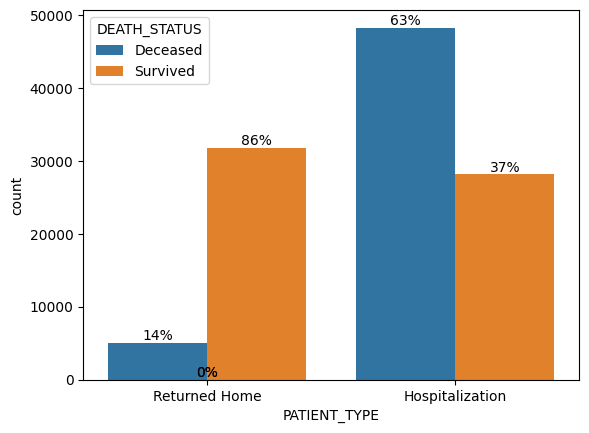

In [ ]:
ax = sns.countplot(x='PATIENT_TYPE', data=positive_patient, hue='DEATH_STATUS')
barPerc(positive_patient, 'PATIENT_TYPE', ax)

Sudah kuduga, grafik di atas dapat memperkuat dugaan banyak orang yang mengatakan kalau seseorang diduga terkena COVID jangan lapor ke rumah sakit atau klinik kesehatan lain dan hanya istirahat saja di rumah.

## Status Kehamilan

In [ ]:
female_patient = data_covid[data_covid['SEX']=='Female']

In [ ]:
female_patient['PREGNANT'].value_counts()

2     102049
1       3020
98      1954
Name: PREGNANT, dtype: int64

In [ ]:
def bool_features(x):
  if x == 1:
    return 'Yes'
  elif x == 2:
    return 'No'
  else:
    return 'No'

In [ ]:
data_covid['PREGNANT'] = data_covid['PREGNANT'].apply(bool_features)
female_patient['PREGNANT'] = female_patient['PREGNANT'].apply(bool_features)

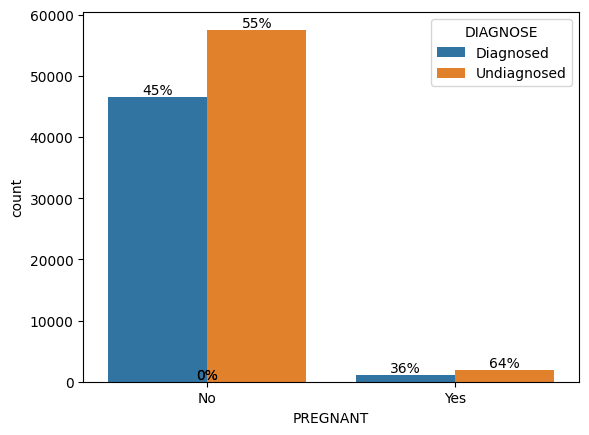

In [ ]:
ax = sns.countplot(x='PREGNANT', data=female_patient, hue='DIAGNOSE')
barPerc(female_patient, 'PREGNANT', ax)

Menurut grafik di atas, COVID lebih suka menjangkiti wanita yang tidak hamil walaupun wanita yang tidak hamil lebih banyak yang tidak terjangkit COVID

## Gaya Hidup

In [ ]:
lifestyle = pd.DataFrame(data_covid, columns=['OBESITY','TOBACCO','DIAGNOSE'])
lifestyle.head()

,OBESITY,TOBACCO,DIAGNOSE
0,2,2,Diagnosed
1,1,2,Undiagnosed
2,2,2,Diagnosed
3,2,2,Undiagnosed
4,2,2,Diagnosed


In [ ]:
data_covid['OBESITY'] = data_covid['OBESITY'].apply(bool_features)
data_covid['TOBACCO'] = data_covid['TOBACCO'].apply(bool_features)
lifestyle['OBESITY'] = lifestyle['OBESITY'].apply(bool_features)
lifestyle['TOBACCO'] = lifestyle['TOBACCO'].apply(bool_features)

lifestyle.head()

,OBESITY,TOBACCO,DIAGNOSE
0,No,No,Diagnosed
1,Yes,No,Undiagnosed
2,No,No,Diagnosed
3,No,No,Undiagnosed
4,No,No,Diagnosed


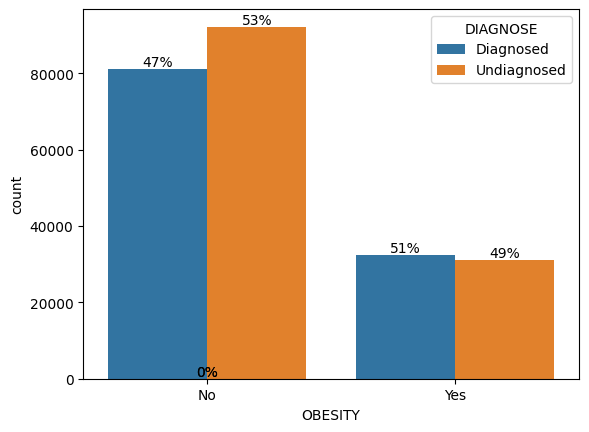

In [ ]:
ax = sns.countplot(x='OBESITY', data=lifestyle, hue='DIAGNOSE')
barPerc(lifestyle, 'OBESITY', ax)

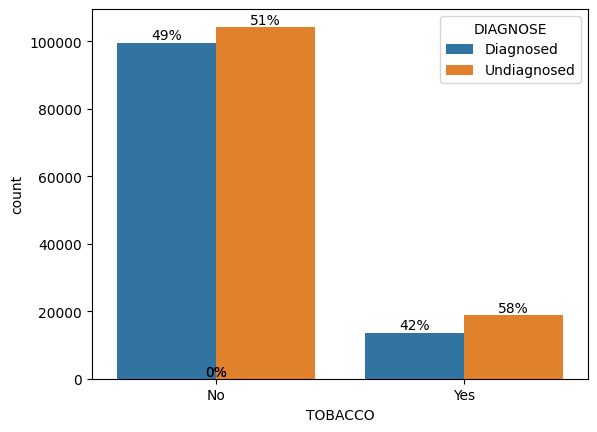

In [ ]:
ax = sns.countplot(x='TOBACCO', data=lifestyle, hue='DIAGNOSE')
barPerc(lifestyle, 'TOBACCO', ax)

Dari kedua grafik di atas, bisa dilihat bahwa hanya pasien yang mengalami kelebihan berat badan (obesitas) yang memiliki risiko tinggi terjangkit COVID. Namun secara mengejutkan, pasien perokok yang terjangkit COVID lebih sedikit daripada yang tidak. Padahal, rokok adalah salah satu sumber pemicu penyakit pernafasan dan COVID adalah penyakit yang menyerang sistem pernafasan.

## Penyakit Bawaan

In [ ]:
disease = ['PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR',
           'HIPERTENSION','CARDIOVASCULAR','RENAL_CHRONIC','OTHER_DISEASE']

In [ ]:
carrier_disease = pd.DataFrame(data_covid, columns=disease)

In [ ]:
for col in carrier_disease.columns:
  data_covid[col] = data_covid[col].apply(bool_features)
  carrier_disease[col] = carrier_disease[col].apply(bool_features)

In [ ]:
carrier_disease.head()

,PNEUMONIA,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,CARDIOVASCULAR,RENAL_CHRONIC,OTHER_DISEASE
0,Yes,No,No,No,No,Yes,No,No,No
1,Yes,No,No,No,No,Yes,No,Yes,No
2,No,Yes,No,No,No,No,No,No,No
3,No,No,No,No,No,No,No,No,No
4,No,Yes,No,No,No,Yes,No,No,No


In [ ]:
disease = ['PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR',
           'HIPERTENSION','CARDIOVASCULAR','RENAL_CHRONIC','OTHER_DISEASE','DIAGNOSE']

carrier_disease = pd.DataFrame(data_covid, columns=disease)

In [ ]:
carrier_disease.head()

,PNEUMONIA,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,CARDIOVASCULAR,RENAL_CHRONIC,OTHER_DISEASE,DIAGNOSE
0,Yes,No,No,No,No,Yes,No,No,No,Diagnosed
1,Yes,No,No,No,No,Yes,No,Yes,No,Undiagnosed
2,No,Yes,No,No,No,No,No,No,No,Diagnosed
3,No,No,No,No,No,No,No,No,No,Undiagnosed
4,No,Yes,No,No,No,Yes,No,No,No,Diagnosed


In [ ]:
disease = ['PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR',
           'HIPERTENSION','CARDIOVASCULAR','RENAL_CHRONIC','OTHER_DISEASE']

In [ ]:
def disease_plot(disease):
  ax = sns.countplot(x=disease, data=carrier_disease, hue='DIAGNOSE')
  barPerc(carrier_disease, disease, ax)

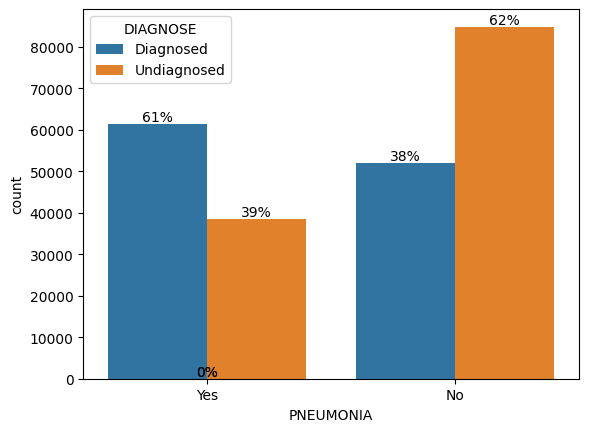

In [ ]:
disease_plot('PNEUMONIA')

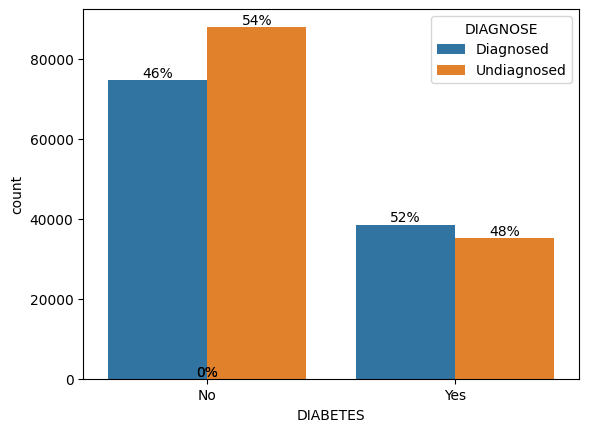

In [ ]:
disease_plot('DIABETES')

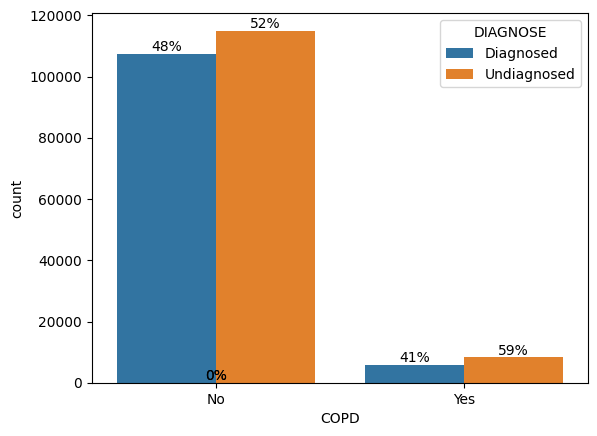

In [ ]:
disease_plot('COPD')

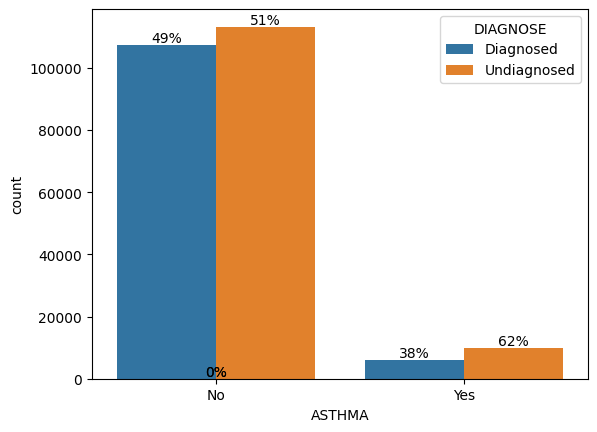

In [ ]:
disease_plot('ASTHMA')

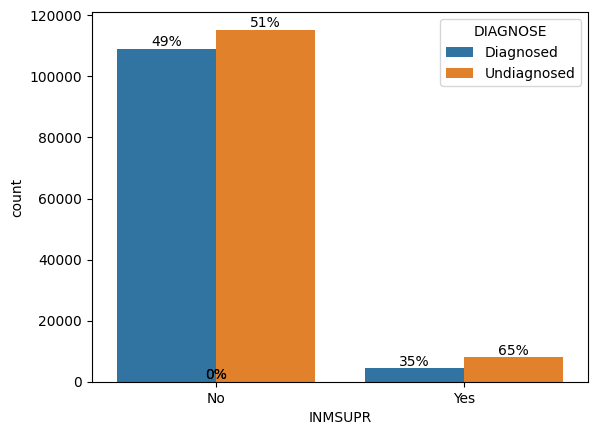

In [ ]:
disease_plot('INMSUPR')

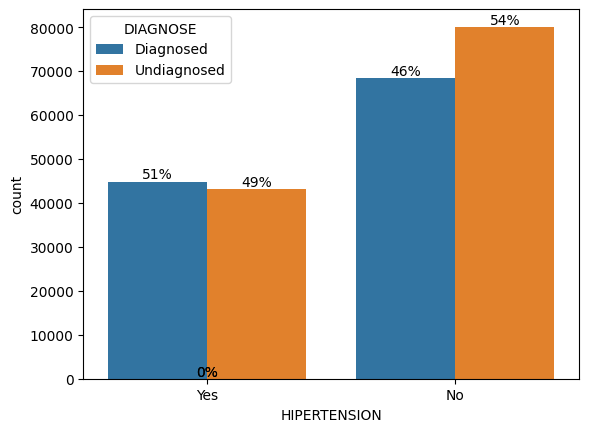

In [ ]:
disease_plot('HIPERTENSION')

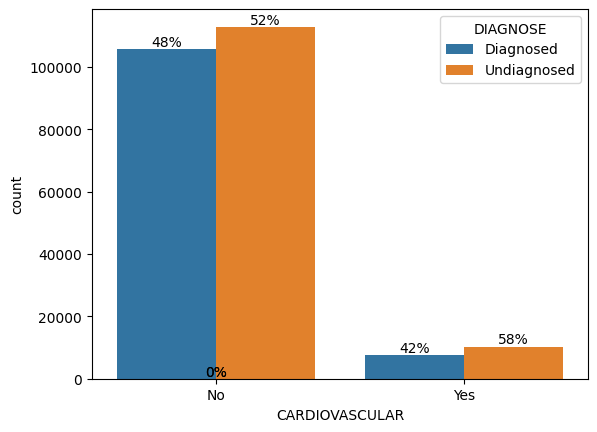

In [ ]:
disease_plot('CARDIOVASCULAR')

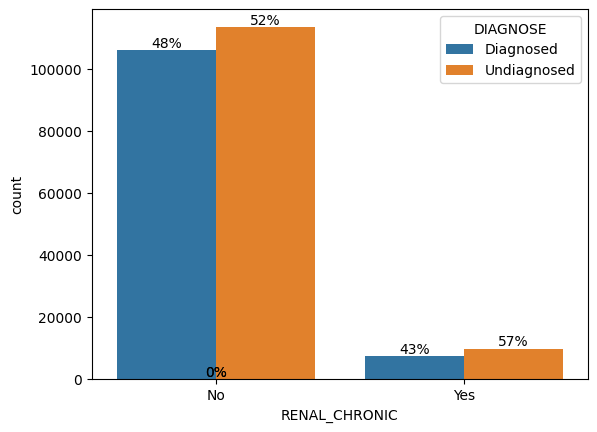

In [ ]:
disease_plot('RENAL_CHRONIC')

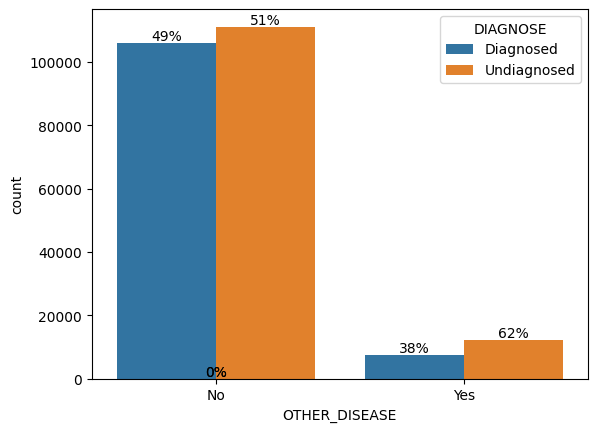

In [ ]:
disease_plot('OTHER_DISEASE')

Dari beberapa grafik hubungan penyakit bawaan dengan status COVID, penyakit bawaan yang diduga berpengaruh terhadap status COVID adalah (1) Pneumonia (2) Diabetes (3) Hipertensi. Pneumonia (infeksi pada kantung-kantung udara dalam paru-paru) tercatat sebagai penyakit bawaan yang paling mudah dijangkiti COVID. Di samping itu semua, semua penyakit bawaan yang dianalisa tadi memberi pengaruh yang cukup besar terhadap status COVID meskipun selisihnya tidak terlalu jauh terhadap yang tidak terjangkit COVID.

# Data Splitting

Oke, tahap selanjutnya adalah data splitting. Sebelum memisahkan data, alangkah baiknya memilih fitur yang dirasa diperlukan dalam pembuatan machine learning kali ini. Kemudian, hilangkan data duplikat sekali lagi.

## Memilih Features

In [ ]:
model = data_covid.copy()

In [ ]:
model.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DIAGNOSE,DEATH_STATUS
0,2,1,Female,Returned Home,03/05/2020,97,Yes,65,No,No,...,Yes,No,No,No,No,No,3,97,Diagnosed,Deceased
1,2,1,Male,Returned Home,03/06/2020,97,Yes,72,No,No,...,Yes,No,No,Yes,Yes,No,5,97,Undiagnosed,Deceased
2,2,1,Male,Hospitalization,09/06/2020,1,No,55,No,Yes,...,No,No,No,No,No,No,3,2,Diagnosed,Deceased
3,2,1,Female,Returned Home,12/06/2020,97,No,53,No,No,...,No,No,No,No,No,No,7,97,Undiagnosed,Deceased
4,2,1,Male,Returned Home,21/06/2020,97,No,68,No,Yes,...,Yes,No,No,No,No,No,3,97,Diagnosed,Deceased


In [ ]:
columns_model = model.columns.to_list()
columns_model

['USMER',
 'MEDICAL_UNIT',
 'SEX',
 'PATIENT_TYPE',
 'DATE_DIED',
 'INTUBED',
 'PNEUMONIA',
 'AGE',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'CLASIFFICATION_FINAL',
 'ICU',
 'DIAGNOSE',
 'DEATH_STATUS']

In [ ]:
columns_model = ['AGE','SEX','PNEUMONIA','PREGNANT','DIABETES',
                 'COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE',
                 'CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO','DIAGNOSE']
columns_model

['AGE',
 'SEX',
 'PNEUMONIA',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'DIAGNOSE']

In [ ]:
model = pd.DataFrame(model, columns=columns_model)
model.head()

,AGE,SEX,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DIAGNOSE
0,65,Female,Yes,No,No,No,No,No,Yes,No,No,No,No,No,Diagnosed
1,72,Male,Yes,No,No,No,No,No,Yes,No,No,Yes,Yes,No,Undiagnosed
2,55,Male,No,No,Yes,No,No,No,No,No,No,No,No,No,Diagnosed
3,53,Female,No,No,No,No,No,No,No,No,No,No,No,No,Undiagnosed
4,68,Male,No,No,Yes,No,No,No,Yes,No,No,No,No,No,Diagnosed


## Menghapus Data Duplikat

In [ ]:
model.duplicated().sum()

191875

In [ ]:
model_final = model.drop_duplicates()
model_final.shape

(44651, 15)

## Memisahkan Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Memisahkan data menjadi 80% train dan 20% test
x = model_final.drop('DIAGNOSE', axis=1)
y = model_final['DIAGNOSE']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

In [ ]:
y_train.value_counts(normalize=True)

Undiagnosed    0.550308
Diagnosed      0.449692
Name: DIAGNOSE, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

Undiagnosed    0.550218
Diagnosed      0.449782
Name: DIAGNOSE, dtype: float64

# Preprocessing

Langkah pertama sebelum membuat model machine learning adalah data preprocessing. Kali ini, data preprocessing yaitu (1) mengubah data kategori menjadi data numerik (2) mengubah data numerik dengan menggunakan MinMax Scaler

## Data kategori menjadi data numerik

In [ ]:
sex_model = {'Female':0, 'Male':1}

In [ ]:
x_train['SEX'] = x_train['SEX'].map(sex_model)
x_test['SEX'] = x_test['SEX'].map(sex_model)

In [ ]:
bool_model = {'No':0, 'Yes':1}

In [ ]:
disease_model = ['PNEUMONIA','DIABETES','COPD','ASTHMA','INMSUPR',
                 'HIPERTENSION','CARDIOVASCULAR','RENAL_CHRONIC','OTHER_DISEASE']

In [ ]:
for col in disease_model:
  x_train[col] = x_train[col].map(bool_model)
  x_test[col] = x_test[col].map(bool_model)

In [ ]:
condition = ['PREGNANT','OBESITY','TOBACCO']

In [ ]:
for col in condition:
  x_train[col] = x_train[col].map(bool_model)
  x_test[col] = x_test[col].map(bool_model)

In [ ]:
diagnose = {'Undiagnosed':0,'Diagnosed':1}

In [ ]:
y_train = y_train.map(diagnose)
y_test = y_test.map(diagnose)

## MinMax Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
minmax = MinMaxScaler()

In [ ]:
minmax.fit(x_train)

MinMaxScaler()

In [ ]:
def scaling(df, scaler):

  # df["runtime	"] = df["runtime"].div(60)

  scaled_array = scaler.transform(df)
  scaled_df = pd.DataFrame(scaled_array, columns = scaler.get_feature_names_out())

  return scaled_df

In [ ]:
x_train_scaled = scaling(x_train, minmax)
x_test_scaled = scaling(x_test, minmax)

In [ ]:
print(x_train_scaled.head())
print(x_test_scaled.head())

        AGE  SEX  PNEUMONIA  PREGNANT  DIABETES  COPD  ASTHMA  INMSUPR  \
0  0.661157  1.0        0.0       0.0       0.0   0.0     0.0      0.0   
1  0.586777  1.0        1.0       0.0       0.0   0.0     0.0      0.0   
2  0.768595  1.0        0.0       0.0       0.0   0.0     1.0      0.0   
3  0.347107  1.0        0.0       0.0       0.0   0.0     0.0      0.0   
4  0.289256  0.0        0.0       0.0       0.0   0.0     0.0      0.0   

   HIPERTENSION  OTHER_DISEASE  CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  \
0           0.0            0.0             0.0      0.0            0.0   
1           1.0            1.0             1.0      0.0            0.0   
2           0.0            0.0             0.0      0.0            0.0   
3           1.0            0.0             1.0      1.0            0.0   
4           1.0            0.0             0.0      1.0            0.0   

   TOBACCO  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
        AGE  SEX  PNEUMONIA  PRE

# Machine Learning Model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Logistic Reggresion

In [ ]:
logreg = LogisticRegression()

### Non-parameter

In [ ]:
logreg.fit(x_train_scaled, y_train)
y_pred = logreg.predict(x_test_scaled)

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, y_pred)
matrix

array([[3875, 1039],
       [2889, 1128]])

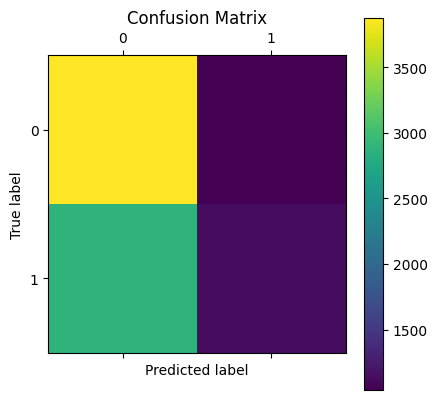

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(matrix)
plt.colorbar()

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

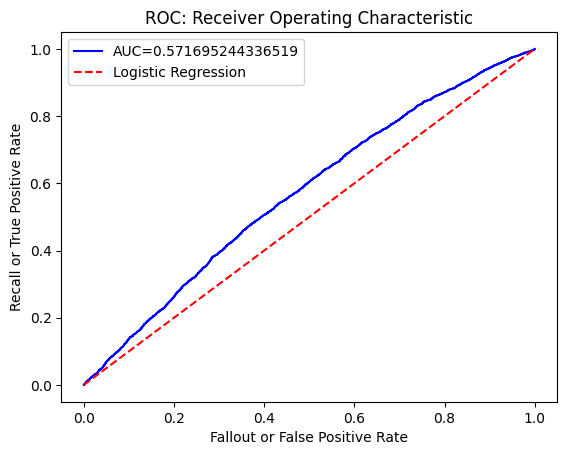

In [ ]:
from sklearn.metrics import roc_curve, auc

prob_estimates = logreg.predict_proba(x_test_scaled)

fpr, tpr, threshhold = roc_curve(y_test, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label=f'AUC={nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Logistic Regression')

plt.title('ROC: Receiver Operating Characteristic')
plt.xlabel('Fallout or False Positive Rate')
plt.ylabel('Recall or True Positive Rate')
plt.legend()
plt.show()

### Parameter

In [ ]:
logreg_param = {'C': [1,10],
                'solver': ['liblinear', 'lbfgs'],
                'max_iter':[100,200]}

In [ ]:
logreg_1 = GridSearchCV(logreg, logreg_param)

In [ ]:
logreg_1.fit(x_train_scaled,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [1, 10], 'max_iter': [100, 200],
                         'solver': ['liblinear', 'lbfgs']})

In [ ]:
logreg_1.best_params_

{'C': 10, 'max_iter': 100, 'solver': 'liblinear'}

In [ ]:
logreg_1.best_score_

0.56503359462486

In [ ]:
logreg_new = LogisticRegression(C=10, max_iter=100, solver='lbfgs')

In [ ]:
logreg_new.fit(x_train_scaled, y_train)
y_pred = logreg_new.predict(x_test_scaled)

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[3875, 1039],
       [2888, 1129]])

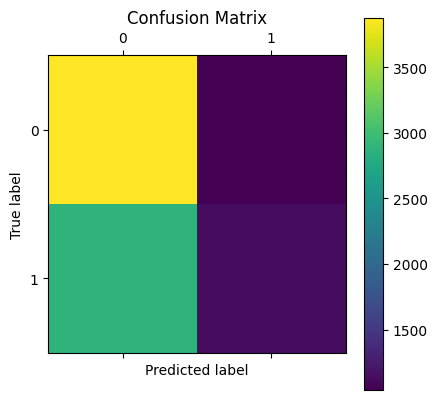

In [ ]:
plt.matshow(matrix)
plt.colorbar()

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

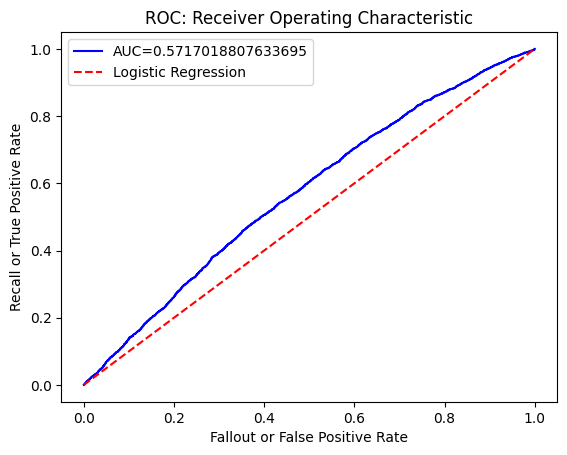

In [ ]:
prob_estimates = logreg_new.predict_proba(x_test_scaled)

fpr, tpr, threshhold = roc_curve(y_test, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label=f'AUC={nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Logistic Regression')

plt.title('ROC: Receiver Operating Characteristic')
plt.xlabel('Fallout or False Positive Rate')
plt.ylabel('Recall or True Positive Rate')
plt.legend()
plt.show()

## K-Neighbour Classifier

In [ ]:
knn = KNeighborsClassifier()

### Non-parameter

In [ ]:
knn.fit(x_train_scaled,y_train)
y_pred = knn.predict(x_test_scaled)

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[2365, 2549],
       [2814, 1203]])

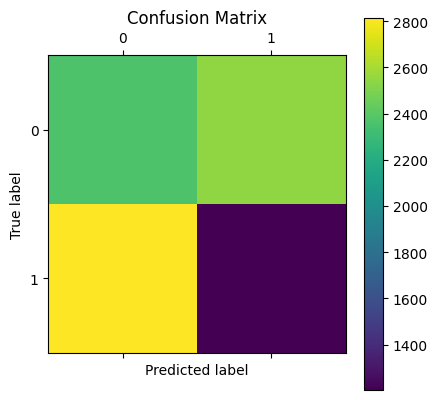

In [ ]:
plt.matshow(matrix)
plt.colorbar()

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

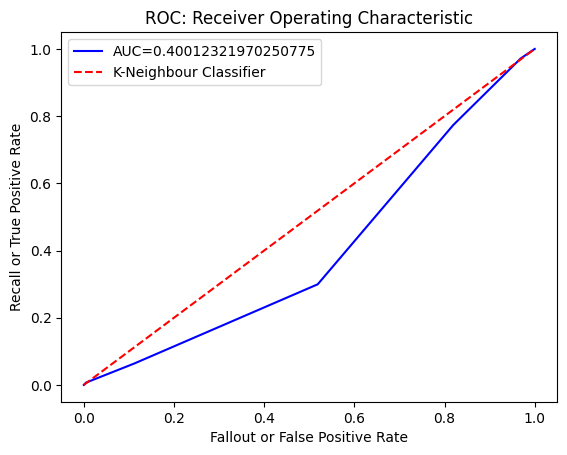

In [ ]:
prob_estimates = knn.predict_proba(x_test_scaled)

fpr, tpr, threshhold = roc_curve(y_test, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label=f'AUC={nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='K-Neighbour Classifier')

plt.title('ROC: Receiver Operating Characteristic')
plt.xlabel('Fallout or False Positive Rate')
plt.ylabel('Recall or True Positive Rate')
plt.legend()
plt.show()

### Parameter

In [ ]:
knn_param = {'n_neighbors':[4,5,6],
             'algorithm':['auto', 'ball_tree', 'kd_tree'],
             'p':[1,2]}

In [ ]:
knn_1 = GridSearchCV(knn, knn_param)

In [ ]:
knn_1.fit(x_train_scaled,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'n_neighbors': [4, 5, 6], 'p': [1, 2]})

In [ ]:
knn_1.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 6, 'p': 1}

In [ ]:
knn_1.best_score_

0.4761478163493841

In [ ]:
knn_new = KNeighborsClassifier(n_neighbors=6, algorithm='ball_tree', p=1)

In [ ]:
knn_new.fit(x_train_scaled,y_train)
y_pred = knn_new.predict(x_test_scaled)

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[3491, 1423],
       [3422,  595]])

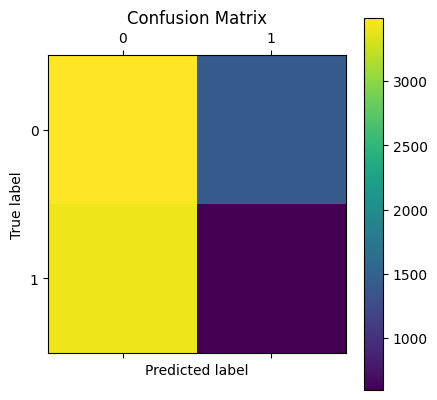

In [ ]:
plt.matshow(matrix)
plt.colorbar()

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

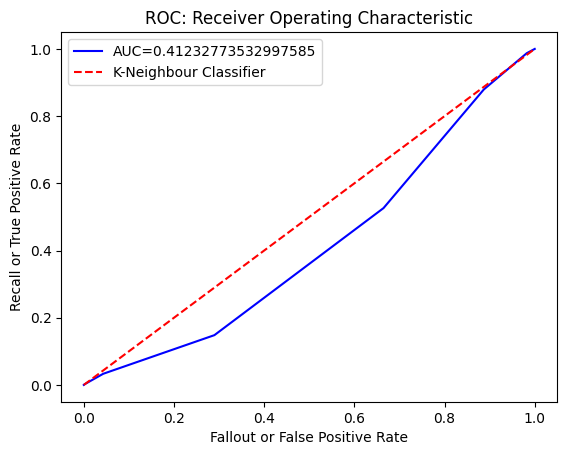

In [ ]:
prob_estimates = knn_new.predict_proba(x_test_scaled)

fpr, tpr, threshhold = roc_curve(y_test, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label=f'AUC={nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='K-Neighbour Classifier')

plt.title('ROC: Receiver Operating Characteristic')
plt.xlabel('Fallout or False Positive Rate')
plt.ylabel('Recall or True Positive Rate')
plt.legend()
plt.show()

## Random Forest

In [ ]:
forest = RandomForestClassifier()

### Non-parameter

In [ ]:
forest.fit(x_train_scaled,y_train)
y_pred = forest.predict(x_test_scaled)

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[1834, 3080],
       [3136,  881]])

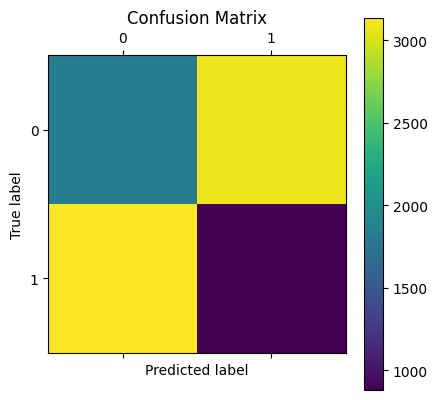

In [ ]:
plt.matshow(matrix)
plt.colorbar()

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

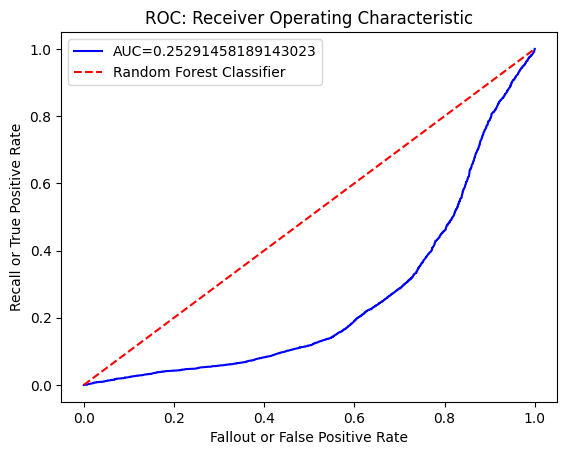

In [ ]:
prob_estimates = forest.predict_proba(x_test_scaled)

fpr, tpr, threshhold = roc_curve(y_test, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label=f'AUC={nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Random Forest Classifier')

plt.title('ROC: Receiver Operating Characteristic')
plt.xlabel('Fallout or False Positive Rate')
plt.ylabel('Recall or True Positive Rate')
plt.legend()
plt.show()

### Parameter

In [ ]:
forest_param = {'n_estimators':[100,200,300],
                'criterion':['gini','entropy'],
                'max_depth':[0,1,2]}

In [ ]:
forest_1 = GridSearchCV(forest, forest_param)

In [ ]:
forest_1.fit(x_train_scaled,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 1, 2],
                         'n_estimators': [100, 200, 300]})

In [ ]:
forest_1.best_params_

{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 100}

In [ ]:
forest_1.best_score_

0.5503079507278834

In [ ]:
forest_new = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=1)

In [ ]:
forest_new.fit(x_train_scaled,y_train)
y_pred = forest_new.predict(x_test_scaled)

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[4914,    0],
       [4017,    0]])

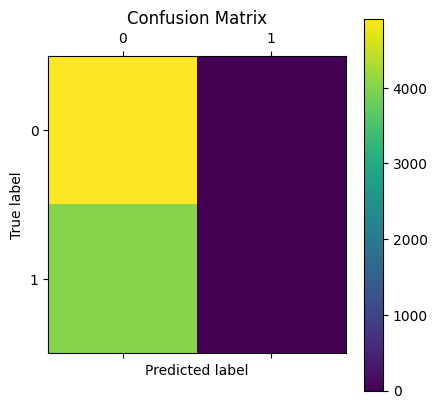

In [ ]:
plt.matshow(matrix)
plt.colorbar()

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

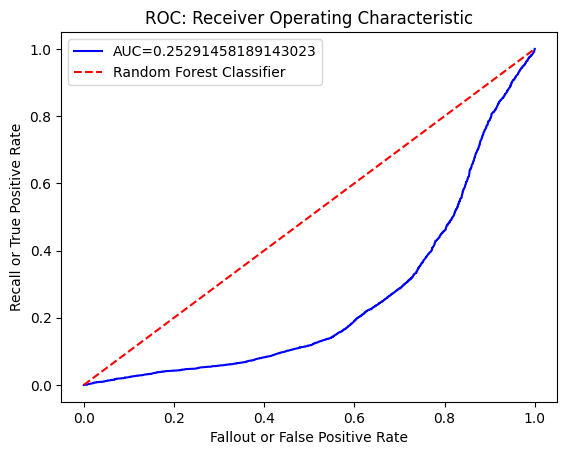

In [ ]:
prob_estimates = forest.predict_proba(x_test_scaled)

fpr, tpr, threshhold = roc_curve(y_test, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label=f'AUC={nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Random Forest Classifier')

plt.title('ROC: Receiver Operating Characteristic')
plt.xlabel('Fallout or False Positive Rate')
plt.ylabel('Recall or True Positive Rate')
plt.legend()
plt.show()

## Model Terbaik

Setelah melakukan pemodelan dengan 3 macam model machine learning yaitu Logistic Regressions, K-Neighbour, dan Random Forest, model dengan nilai pengukuran terbaik adalah Logistic Regressions dengan parameter. Meskipun begitu, nilai pengukuran (ROC-AUC) model tersebut hanya bernilai 0,57170. Dengan nilai itu, model ttersebut masih dianggap kurang layak untuk memprediksi apakah pasien terjangkit COVID atau tidak. Kemungkinan, pengukuran tes COVID dari sana memang masih diragukan keakuratannya sesuai penjelasan awal dari dataset. Apalagi, satu-satunya cara mengetahui seseorang terjangkit COVID hanya dengan mengetesnya dengan tes COVID tersebut karena ada orang yang kelihatanya sehat-sehat saja positif terkena COVID setelah ditest.

# Kesimpulan

Setelah melakukan analisis dan pemodelan, kesimpulan yang bisa diambil dari kegiatan tersebut yaitu

1.   Banyak pasien yang meninggal karena COVID, namun sebagian besar pasien tersebut meninggal di rumah sakit. Hal ini dapat memperkuat argumentasi dari nasihat banyak orang saat pandemi berlangsung yaitu "Kalau merasa sakit, jangan pernah ke rumah sakit dan istirahat saja di rumah".
2.   Tes COVID yang digunakan pada saat pandemi berlangsung ternyata masih diragukan keakuratannya dan masih dapat memvonis positif COVID kepada seseorang yang kelihatannya sehat dan tanpa riwayat penyakit apapun. Gejala dari COVID sebenarnya masih tidak jelas sampai saat analisis ini dilakukan.




















